In [1]:
import jax

jax.config.update("jax_enable_x64", True)

import galsim
import numpy as np
import jax.numpy as jnp
import jax_galsim.core.interpolate

In [2]:
import matplotlib.pyplot as plt

## Define Range of Interpolant and Spacings

In [169]:
beta_min = 1.1 + 1e-6
beta_max = 100
n_beta = 100  # used to fit the rational function approx
mkts_min = 1e-12
mkts_max = 0.1
n_mkts = 100  # we build this many rational function approximations
RATNL_ORDER = 7

betas = np.logspace(np.log10(beta_min), np.log10(beta_max), n_beta)
mkts = np.logspace(jnp.log10(mkts_min), jnp.log10(mkts_max), n_mkts)

# this is the function we are interpolating
def _fun(beta, sr, mkt):
    return galsim.Moffat(
        beta,
        scale_radius=sr
    ).withGSParams(maxk_threshold=mkt).maxk

## Build rational function apprx. in beta at fixed maxk_threshold

In [170]:
import scipy.optimize
import numpy.polynomial
from numpy.polynomial import Polynomial

numpy.polynomial.set_default_printstyle("ascii")


def get_ratnl_func_polys(coeff):
    p_coeff = coeff[0 : RATNL_ORDER + 1]
    q_coeff = np.concatenate([[1], coeff[RATNL_ORDER + 1 :]])
    pm = Polynomial(p_coeff)
    qm = Polynomial(q_coeff)
    return pm, qm


def get_ratnl_func_coeffs(coeff):
    p_coeff = coeff[0 : RATNL_ORDER + 1]
    q_coeff = np.concatenate([[1], coeff[RATNL_ORDER + 1 :]])
    return p_coeff, q_coeff


def ratnl_func(x, *coeff):
    pm, qm = get_ratnl_func_polys(coeff)
    return pm(x) / qm(x)


def make_poly_code(pm, head="", base_indent=0):
    res = ""
    indent = base_indent
    for c in pm.coef:
        if c == pm.coef[-1]:
            end = ""
        else:
            end = " + x * ("

        if c == pm.coef[0]:
            _hd = head
        else:
            _hd = ""
        res += " " * 4 * indent + f"{_hd}{c}{end}\n"
        if c != pm.coef[-1]:
            indent += 1

    for _ in pm.coef[:-1]:
        indent -= 1
        res += " " * 4 * indent + ")\n"

    return res

In [171]:
eps = 1e-6

poly_res = []

for mkt in mkts:
    vals = np.array([_fun(beta, 1.0, mkt) for beta in betas])

    res = scipy.optimize.curve_fit(
        ratnl_func,
        np.log(betas),
        np.log(vals),
        p0=np.ones(2 * RATNL_ORDER + 1),
        full_output=True,
        maxfev=100000,
        ftol=eps,
        xtol=eps,
    )

    coeff = res[0]

    pm, qm = get_ratnl_func_coeffs(coeff)

    poly_res.append((pm[::-1], qm[::-1]))

In [172]:
import textwrap

pstr = textwrap.indent(
    np.array2string(np.array(poly_res), floatmode="unique", threshold=100000000, separator=", ", max_line_width=120, sign="+"),
    "    ",
)

In [ ]:
code = f"""\
# START OF GENERATED CODE
# The code in this block is generated by the notebook dev/notebooks/moffat_maxk_interp.ipynb.

MKTS_MIN = {mkts_min}
MKTS_MAX = {mkts_max}
N_MKTS = {n_mkts}
LOG_MKTS = np.log(np.logspace(jnp.log10(MKTS_MIN), jnp.log10(MKTS_MAX), N_MKTS))

# RATIONAL_POLY_VALS is an array of 7-th order ration function approximations
# for maxk as a function of log(beta) at fixed maxk_threshold values. the coeffs
# are stored from highest degree to lowest. The shape of the array is
# ({n_mkts}, 2, {RATNL_ORDER + 1}).
# fmt: off
RATIONAL_POLY_VALS = np.array(
{pstr},
    dtype=np.float64,
)
# fmt: on


@jax.jit
def _moffat_maxk(beta, maxk_threshold, r0):
    log_beta = jnp.log(beta)
    log_maxk_threshold = jnp.log(maxk_threshold)
    maxk_vals = jnp.array(
        [
            jnp.exp(
                jnp.polyval(RATIONAL_POLY_VALS[i, 0, :], log_beta)
                / jnp.polyval(RATIONAL_POLY_VALS[i, 1, :], log_beta)
            )
            for i in range(N_MKTS)
        ]
    )
    coeffs = akima_interp_coeffs(LOG_MKTS, maxk_vals)
    return akima_interp(log_maxk_threshold, LOG_MKTS, maxk_vals, coeffs) / r0


# END OF GENERATED CODE
"""

print(code)

# START OF GENERATED CODE
# The code in this block is generated by the notebook dev/notebooks/moffat_maxk_interp.ipynb.

MKTS_MIN = 1e-12
MKTS_MAX = 0.1
N_MKTS = 100
LOG_MKTS = np.log(np.logspace(jnp.log10(MKTS_MIN), jnp.log10(MKTS_MAX), N_MKTS))

# RATIONAL_POLY_VALS is an array of 7-th order ration function approximations
# for maxk as a function of log(beta) at fixed maxk_threshold values. the coeffs
# are stored from highest degree to lowest. The shape of the array is
# (100, 2, 8).
# fmt: off
RATIONAL_POLY_VALS = np.array(
    [[[+1.3772407257259811e+00, +8.2308765855395478e+01, -2.7113255852810147e+02, +2.8334246555296641e+03,
       +1.9765894617972574e+03, -3.0250584335304524e-02, +5.2517275092954705e+01, +3.1088883127707301e+00],
      [-6.6159277500114799e-01, +2.3300377617130614e+01, -1.2112785124653568e+02, +8.2257031521055592e+02,
       +6.1224358735540159e+02, +9.9091301692586009e-02, +1.6041932331486805e+01, +1.0000000000000000e+00]],

     [[+2.9301469618244234e+00, +1

## Testing

In [174]:
from jax_galsim.core.interpolate import akima_interp, akima_interp_coeffs

exec(code)

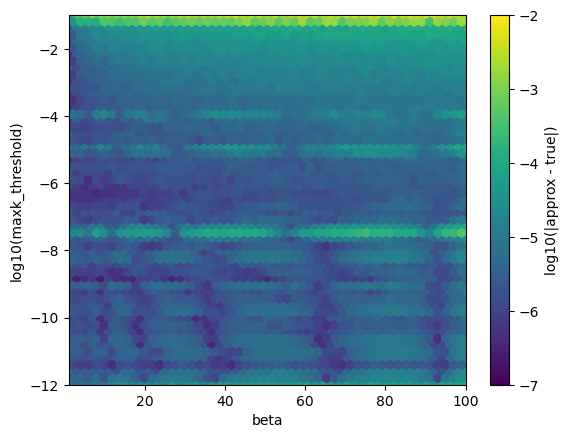

In [175]:
rng = np.random.default_rng(seed=10)
n_test = 100000

betas = rng.uniform(low=1.1 + 1e-6, high=100, size=n_test)
maxk_thresholds = 10**rng.uniform(low=-12, high=-1, size=n_test)
apprx = np.array([
    _moffat_maxk(betas[i], maxk_thresholds[i], 1.0)
    for i in range(n_test)
])
true = np.array([
    _fun(betas[i], 1.0, maxk_thresholds[i])
    for i in range(n_test)
])

# plt.hist(true / apprx - 1, bins=25, log=True)
# ax = plt.gca()
# ax.set_xlabel("fractional error in maxk approx.")
# ax.set_ylabel("# of points")

fig, ax = plt.subplots()
hb = ax.hexbin(
    betas,
    np.log10(maxk_thresholds),
    C=np.log10(np.abs(apprx-true)),
    extent=(1.1, 100, -12, -1),
    gridsize=50,
    vmin=-7,
    vmax=-2
)
ax.set_xlim(1.1, 100)
ax.set_ylim(-12, -1)
ax.set_xlabel("beta")
ax.set_ylabel("log10(maxk_threshold)")
fig.colorbar(hb, label="log10(|approx - true|)")